In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from construct import *
import scipy.signal

import sys
sys.path.append('../Tianwen/') # to import ccsds
import ccsds

import ctypes
libfec = ctypes.CDLL('libfec.so')

import struct
import collections
import pathlib

In [2]:
CE5_AOSInsertZone = Struct(
    'unknown' / Hex(Int16ub),
    'timestamp' / Int32ul, # in units of 1s, epoch 2012-08-01 UTC
)

CE5_AOSReplayInsertZone = Struct(
    'unknown' / Bytes(3),
    'timestamp' / Int32ul, # in units of 1s, epoch 2012-08-01 UTC
)

CE5_AOSFrame = Struct(
    'primary_header' / ccsds.AOSPrimaryHeader,
    'insert_zone' / CE5_AOSInsertZone,
    'data_field' / GreedyBytes
)

CE5_AOSReplayFrame = Struct(
    'primary_header' / ccsds.AOSPrimaryHeader,
    'insert_zone' / CE5_AOSReplayInsertZone,
    'm_pdu_header' / ccsds.M_PDU_Header,
    'm_pdu_packet_zone' / Bytes(235),
    'crc' / Bytes(2)
)

def get_packet(p):
    return p[0] if type(p) is tuple else p

def packets_asarray(packets):
    return np.array([np.frombuffer(get_packet(p)[ccsds.SpacePacketPrimaryHeader.sizeof():], 'uint8')
                     for p in packets])

def plot_apids(apids, sc, vc):
    for apid in sorted(apids.keys()):
        plt.figure(figsize = (16,16), facecolor = 'w')
        ps = packets_asarray(apids[apid])
        plt.imshow(ps, aspect = ps.shape[1]/ps.shape[0])
        plt.title(f"Chang'e 5 APID {apid} Virtual channel {vc}")

def get_packet_timestamps(packets):
    return np.datetime64('2012-08-01') + np.timedelta64(1,'s')*np.array([p[1] for p in packets])

crc_table = [0x0000, 0x1021, 0x2042, 0x3063, 0x4084, 0x50a5, 0x60c6, 0x70e7,
    0x8108, 0x9129, 0xa14a, 0xb16b, 0xc18c, 0xd1ad, 0xe1ce, 0xf1ef,
    0x1231, 0x0210, 0x3273, 0x2252, 0x52b5, 0x4294, 0x72f7, 0x62d6,
    0x9339, 0x8318, 0xb37b, 0xa35a, 0xd3bd, 0xc39c, 0xf3ff, 0xe3de,
    0x2462, 0x3443, 0x0420, 0x1401, 0x64e6, 0x74c7, 0x44a4, 0x5485,
    0xa56a, 0xb54b, 0x8528, 0x9509, 0xe5ee, 0xf5cf, 0xc5ac, 0xd58d,
    0x3653, 0x2672, 0x1611, 0x0630, 0x76d7, 0x66f6, 0x5695, 0x46b4,
    0xb75b, 0xa77a, 0x9719, 0x8738, 0xf7df, 0xe7fe, 0xd79d, 0xc7bc,
    0x48c4, 0x58e5, 0x6886, 0x78a7, 0x0840, 0x1861, 0x2802, 0x3823,
    0xc9cc, 0xd9ed, 0xe98e, 0xf9af, 0x8948, 0x9969, 0xa90a, 0xb92b,
    0x5af5, 0x4ad4, 0x7ab7, 0x6a96, 0x1a71, 0x0a50, 0x3a33, 0x2a12,
    0xdbfd, 0xcbdc, 0xfbbf, 0xeb9e, 0x9b79, 0x8b58, 0xbb3b, 0xab1a,
    0x6ca6, 0x7c87, 0x4ce4, 0x5cc5, 0x2c22, 0x3c03, 0x0c60, 0x1c41,
    0xedae, 0xfd8f, 0xcdec, 0xddcd, 0xad2a, 0xbd0b, 0x8d68, 0x9d49,
    0x7e97, 0x6eb6, 0x5ed5, 0x4ef4, 0x3e13, 0x2e32, 0x1e51, 0x0e70,
    0xff9f, 0xefbe, 0xdfdd, 0xcffc, 0xbf1b, 0xaf3a, 0x9f59, 0x8f78,
    0x9188, 0x81a9, 0xb1ca, 0xa1eb, 0xd10c, 0xc12d, 0xf14e, 0xe16f,
    0x1080, 0x00a1, 0x30c2, 0x20e3, 0x5004, 0x4025, 0x7046, 0x6067,
    0x83b9, 0x9398, 0xa3fb, 0xb3da, 0xc33d, 0xd31c, 0xe37f, 0xf35e,
    0x02b1, 0x1290, 0x22f3, 0x32d2, 0x4235, 0x5214, 0x6277, 0x7256,
    0xb5ea, 0xa5cb, 0x95a8, 0x8589, 0xf56e, 0xe54f, 0xd52c, 0xc50d,
    0x34e2, 0x24c3, 0x14a0, 0x0481, 0x7466, 0x6447, 0x5424, 0x4405,
    0xa7db, 0xb7fa, 0x8799, 0x97b8, 0xe75f, 0xf77e, 0xc71d, 0xd73c,
    0x26d3, 0x36f2, 0x0691, 0x16b0, 0x6657, 0x7676, 0x4615, 0x5634,
    0xd94c, 0xc96d, 0xf90e, 0xe92f, 0x99c8, 0x89e9, 0xb98a, 0xa9ab,
    0x5844, 0x4865, 0x7806, 0x6827, 0x18c0, 0x08e1, 0x3882, 0x28a3,
    0xcb7d, 0xdb5c, 0xeb3f, 0xfb1e, 0x8bf9, 0x9bd8, 0xabbb, 0xbb9a,
    0x4a75, 0x5a54, 0x6a37, 0x7a16, 0x0af1, 0x1ad0, 0x2ab3, 0x3a92,
    0xfd2e, 0xed0f, 0xdd6c, 0xcd4d, 0xbdaa, 0xad8b, 0x9de8, 0x8dc9,
    0x7c26, 0x6c07, 0x5c64, 0x4c45, 0x3ca2, 0x2c83, 0x1ce0, 0x0cc1,
    0xef1f, 0xff3e, 0xcf5d, 0xdf7c, 0xaf9b, 0xbfba, 0x8fd9, 0x9ff8,
    0x6e17, 0x7e36, 0x4e55, 0x5e74, 0x2e93, 0x3eb2, 0x0ed1, 0x1ef0]

def crc16_ccitt_false(data):
    crc = 0xffff
    for d in data:
        tbl_idx = ((crc >> 8) ^ d) & 0xff
        crc = (crc_table[tbl_idx] ^ (crc << 8)) & 0xffff
    return crc & 0xffff

Here we look at some Chang'e 5 high-speed data decoded by Paul Marsh M0EYT.

The frames are CCSDS concatenated frames with a Reed-solomon interleaving depth of 4. The frame size is 1024 bytes including the 32 bit ASM. We need to perform Reed-Solomon decoding with libfec first.

In [3]:
def load_frames(path):
    frame_size = 1024
    frames = np.fromfile(path, dtype = 'uint8')
    frames = frames[:frames.size//frame_size*frame_size].reshape((-1, frame_size))
    # drop ccsds header
    frames = frames[:, 4:]
    return frames


frames = np.concatenate([load_frames(f) for f in sorted(pathlib.Path('uhf_satcom_wideband').glob('*.frm'))[::-1]])
# deinterleave RS frames
frames = np.transpose(frames.reshape((-1,255,4)), axes = (0,2,1)).reshape((-1,255))

rs_ret = [libfec.decode_rs_ccsds(f.ctypes.data_as(ctypes.POINTER(ctypes.c_char)), 0, 0, 0) for f in frames]
frames = frames[:,:-32] # drop RS bytes
frames = np.transpose(frames.reshape((-1,4,223)), axes = (0,2,1)).reshape((-1, 223*4))

/usr/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


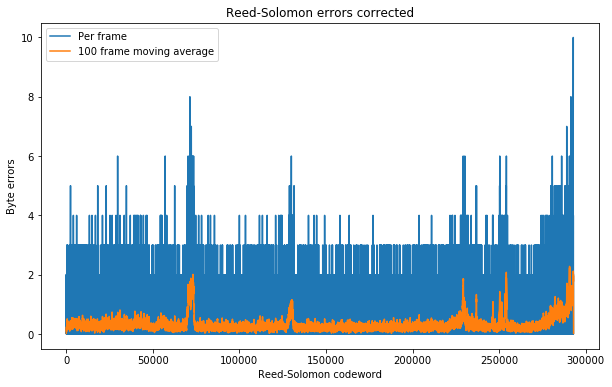

In [4]:
plt.figure(figsize = (10,6), facecolor = 'w')
plt.plot(rs_ret)
plt.plot(np.convolve(rs_ret, 0.01*np.ones(100)))
plt.title('Reed-Solomon errors corrected')
plt.xlabel('Reed-Solomon codeword')
plt.ylabel('Byte errors')
plt.legend(['Per frame', '100 frame moving average']);

## AOS frames

AOS frames come from spacecraft ID 26, virtual channels 38 and 63. Other combinations are most likely to corruted frames despite the fact that the Reed-Solomon decoder was successful.

It's interesting that there are many frames that show a transfer frame version of 2, which looks somewhat anomalous. This should deserve further study.

In [5]:
aos = [CE5_AOSFrame.parse(f) for f in frames]

In [6]:
collections.Counter([a.primary_header.transfer_frame_version_number for a in aos])

Counter({1: 70422, 0: 249, 2: 2466, 3: 92})

In [7]:
collections.Counter([a.primary_header.spacecraft_id for a in aos
                    if a.primary_header.transfer_frame_version_number == 1])

Counter({26: 70258,
         6: 10,
         220: 1,
         214: 1,
         209: 1,
         55: 2,
         177: 5,
         114: 1,
         231: 1,
         89: 2,
         115: 1,
         71: 2,
         238: 1,
         10: 1,
         234: 2,
         94: 1,
         138: 2,
         32: 4,
         81: 3,
         43: 1,
         29: 3,
         73: 4,
         99: 2,
         69: 2,
         45: 3,
         117: 4,
         25: 8,
         65: 2,
         77: 2,
         113: 2,
         125: 15,
         121: 2,
         248: 1,
         57: 2,
         253: 2,
         224: 1,
         178: 5,
         255: 1,
         235: 1,
         31: 1,
         193: 2,
         151: 1,
         149: 1,
         150: 1,
         44: 4,
         217: 1,
         197: 1,
         205: 1,
         201: 1,
         245: 1,
         241: 1,
         249: 1,
         229: 1,
         225: 1,
         237: 1,
         233: 1,
         21: 1,
         17: 1,
         5: 1,
         1: 1,
  

In [8]:
collections.Counter([a.primary_header.virtual_channel_id for a in aos
                    if a.primary_header.transfer_frame_version_number == 1
                    and a.primary_header.spacecraft_id == 26])

Counter({63: 51850, 38: 18396, 1: 1, 56: 2, 45: 3, 58: 1, 2: 4, 61: 1})

## Virtual channel 63

Virtual channel 63 contains padding. Besides the AOS header, there is a 6 byte insert zone which contains `0xf0f0` and a timestamp (in the same format as the low rate telemetry). The remaining data is filled with `0xaa`.

In [9]:
vc63 = [a for a in aos if a.primary_header.virtual_channel_id == 63
       and a.primary_header.transfer_frame_version_number == 1
       and a.primary_header.spacecraft_id == 26]
[a.primary_header for a in vc63[:10]]

[Container(transfer_frame_version_number=1, spacecraft_id=26, virtual_channel_id=63, virtual_channel_frame_count=1027584, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=26, virtual_channel_id=63, virtual_channel_frame_count=1027585, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=26, virtual_channel_id=63, virtual_channel_frame_count=1027586, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=26, virtual_channel_id=63, virtual_channel_frame_count=1027587, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=26, virtual_channel_id=63, virtual_channel_frame_count=1027588, replay_flag=False, vc_frame_co

In [10]:
frames_vc63 = frames[[a.primary_header.virtual_channel_id == 63
                      and a.primary_header.transfer_frame_version_number == 1
                      and a.primary_header.spacecraft_id == 26
                      for a in aos]]

In [11]:
np.unique(frames_vc63[:,12:])

array([170], dtype=uint8)

In [12]:
hex(170)

'0xaa'

In [13]:
{hex(a.insert_zone.unknown) for a in vc63}

{'0xf0f0'}

In [14]:
hex(240)

'0xf0'

In [15]:
vc63_timestamps = np.timedelta64(1,'s')*np.array([a.insert_zone.timestamp for a in vc63])\
    + np.datetime64('2012-08-01')

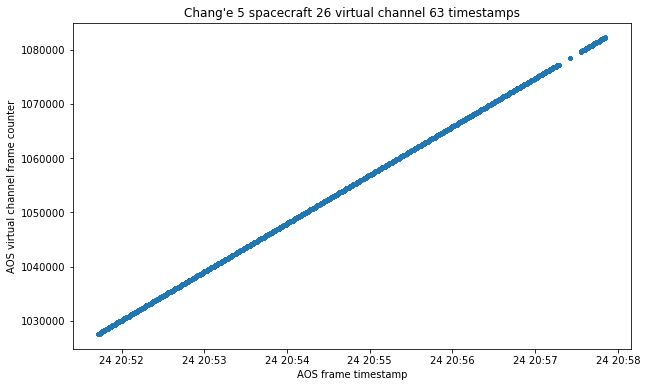

In [16]:
fc = [a.primary_header.virtual_channel_frame_count for a in vc63]

plt.figure(figsize = (10,6), facecolor = 'w')
plt.plot(vc63_timestamps, fc, '.')
plt.title("Chang'e 5 spacecraft 26 virtual channel 63 timestamps")
plt.xlabel('AOS frame timestamp')
plt.ylabel('AOS virtual channel frame counter');

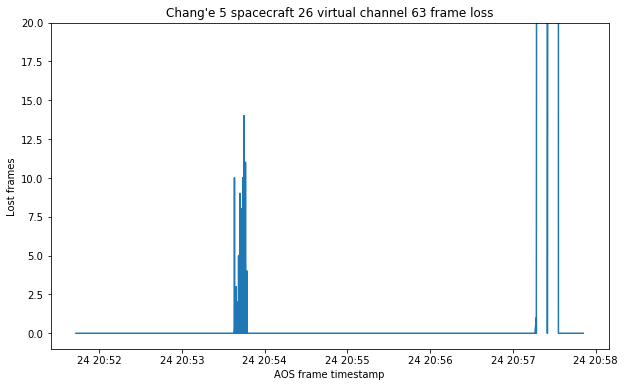

In [17]:
plt.figure(figsize = (10,6), facecolor = 'w')
plt.plot(vc63_timestamps[1:], np.diff(fc)-1)
plt.ylim((-1,20))
plt.title("Chang'e 5 spacecraft 26 virtual channel 63 frame loss")
plt.xlabel('AOS frame timestamp')
plt.ylabel('Lost frames');

In [18]:
frames_per_second = (fc[-1]-fc[0])/(vc63_timestamps[-1] - vc63_timestamps[0]).astype('float')
frames_per_second

148.56521739130434

## Virtual channel 38

The contents of virtual channel 38 are rather complicated due to the large amount of layer present. Here we peel the layers one by one. The first layer are AOS frames with an insert zone just like in virtual channel 63.

The data field of the AOS frames contains a single Space Packet.

In [19]:
vc38 = [a for a in aos if a.primary_header.virtual_channel_id == 38]
[a.primary_header for a in vc38]

[Container(transfer_frame_version_number=1, spacecraft_id=26, virtual_channel_id=38, virtual_channel_frame_count=17323, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=26, virtual_channel_id=38, virtual_channel_frame_count=17324, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=26, virtual_channel_id=38, virtual_channel_frame_count=17325, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=26, virtual_channel_id=38, virtual_channel_frame_count=17326, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=26, virtual_channel_id=38, virtual_channel_frame_count=17327, replay_flag=False, vc_frame_count_usage_

The timestamps of these packets seem to span too much time for this short recording. I think this has something to do with the underlying replay data.

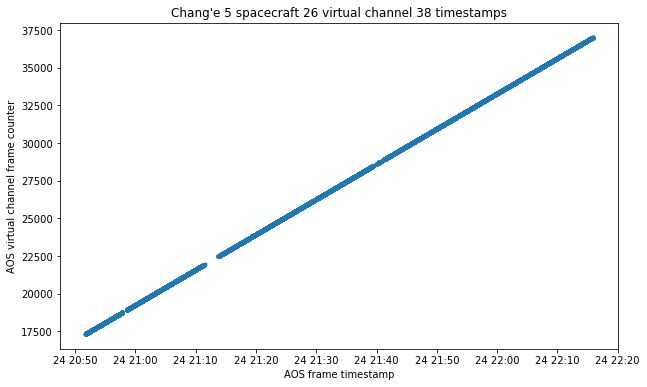

In [20]:
fc = np.array([a.primary_header.virtual_channel_frame_count for a in vc38])
vc38_timestamps = np.timedelta64(1,'s')*np.array([a.insert_zone.timestamp for a in vc38])\
    + np.datetime64('2012-08-01')
good = vc38_timestamps <= np.datetime64('2020-12-01')


plt.figure(figsize = (10,6), facecolor = 'w')
plt.plot(vc38_timestamps[good], fc[good], '.')
plt.title("Chang'e 5 spacecraft 26 virtual channel 38 timestamps")
plt.xlabel('AOS frame timestamp')
plt.ylabel('AOS virtual channel frame counter');

In [21]:
frames_per_second = (fc[-1]-fc[0])/(vc38_timestamps[-1] - vc38_timestamps[0]).astype('float')
frames_per_second

3.899960380348653

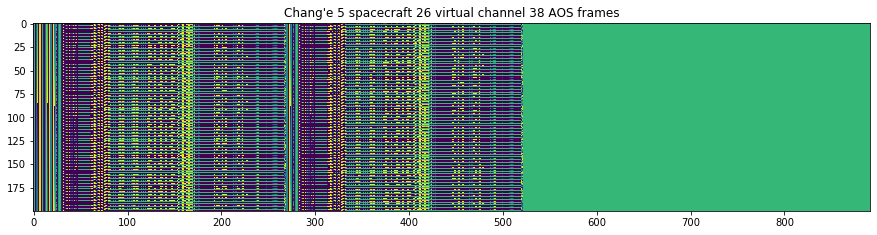

In [22]:
frames_vc38 = frames[[a.primary_header.virtual_channel_id == 38
                      and a.primary_header.transfer_frame_version_number == 1
                      and a.primary_header.spacecraft_id == 26
                      for a in aos]]

plt.figure(figsize = (15,15), facecolor = 'w')
plt.imshow(frames_vc38[:200], aspect = 1)
plt.title("Chang'e 5 spacecraft 26 virtual channel 38 AOS frames");

All the space packets belong to APID 92 and have the same length.

In [23]:
vc38_packet_headers = [ccsds.SpacePacketPrimaryHeader.parse(a.data_field) for a in vc38]
vc38_packet_headers[:10]

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=92, sequence_flags=3, packet_sequence_count_or_name=939, data_length=503),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=92, sequence_flags=3, packet_sequence_count_or_name=940, data_length=503),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=92, sequence_flags=3, packet_sequence_count_or_name=941, data_length=503),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=92, sequence_flags=3, packet_sequence_count_or_name=942, data_length=503),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=92, sequence_flags=3, packet_sequence_count_or_name=943, data_length=503),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=92, sequence_flags=3, packet_sequence_count_or_name=944, data_length=503),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=92, sequenc

In [24]:
collections.Counter([h.APID for h in vc38_packet_headers])

Counter({92: 18396, 1153: 1, 1606: 2, 1409: 1, 2043: 2})

In [25]:
collections.Counter([h.data_length for h in vc38_packet_headers])

Counter({503: 18396, 18299: 1, 43240: 2, 5706: 1, 27701: 2})

In [26]:
data_slice = slice(12 + ccsds.SpacePacketPrimaryHeader.sizeof(),\
                   12 + ccsds.SpacePacketPrimaryHeader.sizeof() + vc38_packet_headers[0].data_length+1)
vc38_packet_data = frames_vc38[:, data_slice]

The end of all the Space Packets is `0xaa` padding.

In [27]:
np.unique(frames_vc38[:, data_slice.stop:])

array([170], dtype=uint8)

The data field of the Space Packets contains two back to back AOS packets of 252 bytes.

The AOS frames have the replay flag set and belong to spacecraft 197 virtual channel 52. The insert zone of these frames contains 3 unknown bytes followed by a 32 bit timestamp in the usual format.

In [28]:
vc38_replay_aos = vc38_packet_data.reshape((vc38_packet_data.shape[0]*2, -1))
vc38_replay_aos_frames = [CE5_AOSReplayFrame.parse(f) for f in vc38_replay_aos]

In [29]:
[a.primary_header for a in vc38_replay_aos_frames[:10]]

[Container(transfer_frame_version_number=1, spacecraft_id=197, virtual_channel_id=52, virtual_channel_frame_count=64592, replay_flag=True, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=197, virtual_channel_id=52, virtual_channel_frame_count=64593, replay_flag=True, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=197, virtual_channel_id=52, virtual_channel_frame_count=64594, replay_flag=True, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=197, virtual_channel_id=52, virtual_channel_frame_count=64595, replay_flag=True, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=197, virtual_channel_id=52, virtual_channel_frame_count=64596, replay_flag=True, vc_frame_count_usage_

In [30]:
{a.primary_header.virtual_channel_id for a in vc38_replay_aos_frames}

{52}

In [31]:
{a.primary_header.spacecraft_id for a in vc38_replay_aos_frames}

{197}

In [32]:
vc38_replay_timestamps = np.timedelta64(1,'s')*np.array([a.insert_zone.timestamp for a in vc38_replay_aos_frames])\
    + np.datetime64('2012-08-01')

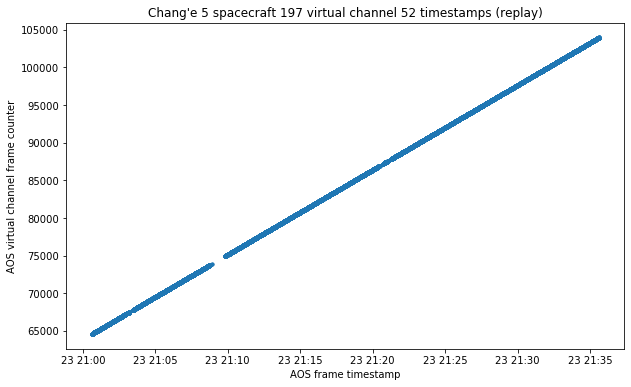

In [33]:
fc = [a.primary_header.virtual_channel_frame_count for a in vc38_replay_aos_frames]

plt.figure(figsize = (10,6), facecolor = 'w')
plt.plot(vc38_replay_timestamps, fc, '.')
plt.title("Chang'e 5 spacecraft 197 virtual channel 52 timestamps (replay)")
plt.xlabel('AOS frame timestamp')
plt.ylabel('AOS virtual channel frame counter');

These AOS frames have a CRC-16. All of the frames are OK.

In [34]:
crc_ok = np.array([crc16_ccitt_false(f) for f in vc38_replay_aos]) == 0

In [35]:
np.all(crc_ok)

True

The replay AOS frames contain Space Packets belonging to APIDs 301 and 2047 (the idle APID).

In [36]:
vc38_replay_packets = list(ccsds.extract_space_packets(vc38_replay_aos_frames, 197, 52))

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 197 VC 52] Broken stream. Last frame count 65493, current frame count 65496
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 197 VC 52] Broken stream. Last frame count 65501, current frame count 65504
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 197 VC 52] Broken stream. Last frame count 65513, current frame count 65516
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Pa

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 197 VC 52] Broken stream. Last frame count 78693, current frame count 78696
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 197 VC 52] Broken stream. Last frame count 78697, current frame count 78700
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 197 VC 52] Broken stream. Last frame count 78705, current frame count 78712
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Pa

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 197 VC 52] Broken stream. Last frame count 103587, current frame count 103590
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 197 VC 52] Broken stream. Last frame count 103597, current frame count 103600
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 197 VC 52] Broken stream. Last frame count 103611, current frame count 103614
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Sp

In [37]:
vc38_replay_packets_headers = [ccsds.SpacePacketPrimaryHeader.parse(p) for p in vc38_replay_packets]

In [38]:
vc38_replay_apids = collections.Counter([p.APID for p in vc38_replay_packets_headers])
vc38_replay_apids

Counter({2047: 12260, 301: 12192})

In [39]:
vc38_replay_by_apid = {apid : [p for h,p in zip(vc38_replay_packets_headers, vc38_replay_packets)
                               if h.APID == apid] for apid in vc38_replay_apids}

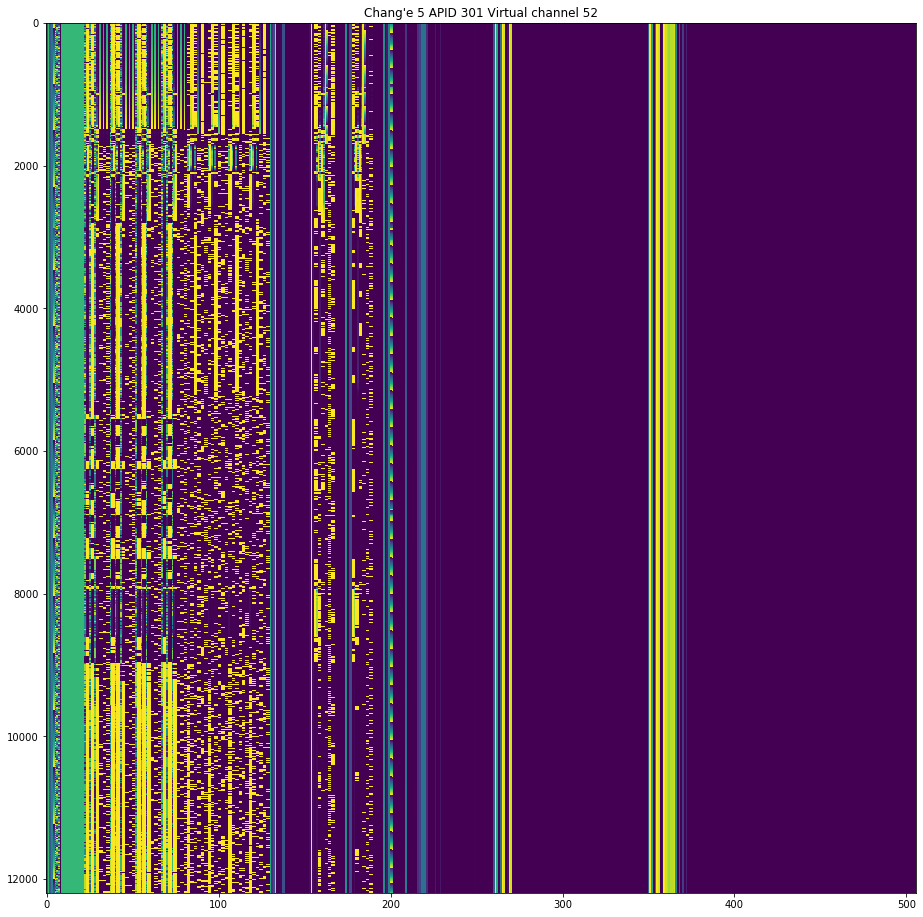

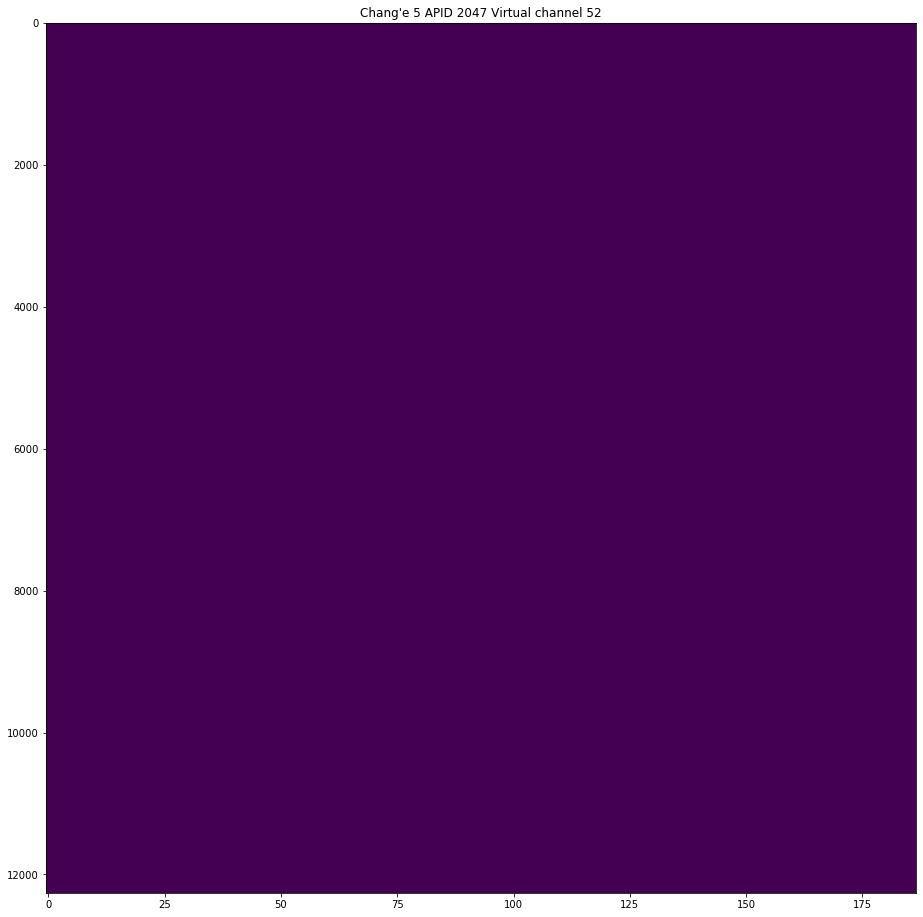

In [40]:
plot_apids(vc38_replay_by_apid, None, 52)